<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/AirTemperature-Trend-Monitoring/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install xee -q
!pip install pymannkendall -q
! pip install netCDF4 -q

## Import Library

In [5]:
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ee
import geemap
import xee
import xarray as xr
import geopandas as gpd
from shapely.geometry import MultiPolygon
import pymannkendall as mk
import requests
from io import BytesIO
import matplotlib.image as mpimg
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import os
import matplotlib as mpl
import pymannkendall as mk


## Initialization of google earth engine

In [6]:
ee.Authenticate()
ee.Initialize(project="ee-saeiddalirisu", opt_url='https://earthengine-highvolume.googleapis.com')

## Inputs

In [37]:
country_name='Italy'
start_time = '1980-01-01'
end_time = '2019-12-31'
dataset_name='ECMWF/ERA5/MONTHLY'
target_band='mean_2m_air_temperature'                  # name of the datast
final_band = 'Air Temperature'                         # initial name of the band  that want to work on that
data_unit= '(°C)'                                      # final vatiable names in plots
operation='Average'                                    # final unit of data (not initial unit)
period = 'Yearly'                                      # analysis interval
resolution = 27830                                     # data resolution in meter
scale_factor = 1                                       # from the metadeta defult=1
offset_factor = 0                                      # from the metadeta defult=0
unit_conversion_factor = 1                             #if to convert the unit the multiplication is required defult=1
unit_conversion_offset = -273.15                       #if to convert the unit the add or subtraction is required defult=0

## Import Data

In [38]:
country = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
    .filter(ee.Filter.eq('country_na', country_name))
roi=country.geometry()
country_geojson = roi.getInfo()
country_geojson_dict = json.dumps(country_geojson)
country_gdf = gpd.read_file(country_geojson_dict)


collection = ee.ImageCollection(dataset_name) \
    .select(target_band) \
    .filterDate(start_time, end_time)\
    .filterBounds(country)\
    .map(lambda image: image.clip(country))

## Convert Data to Xarray

In [39]:
data =  xr.open_dataset(collection, engine = 'ee', crs = 'EPSG:4326', scale = resolution/111320 ,geometry=roi)
data =((data*(scale_factor)+(offset_factor))*(unit_conversion_factor))+(unit_conversion_offset)
data = data.rename({f'{target_band}': f'{final_band}'})
data = data.rename({'time': 'Date'})

## Data Aggregation

In [40]:
data_aggrigated=data.resample(Date='YE').mean('Date')                # Yearly
#data_aggrigated=data.resample(Date='M').mean('Date')                # Montly
#data_aggrigated=data.resample(Date='W').mean('Date')                # Weekly


#data_aggrigated=data.resample(Date='YE').sum('Date')                # Yearly
#data_aggrigated=data.resample(Date='M').sum('Date')                 # Montly
#data_aggrigated=data.resample(Date='W').sum('Date')                 # Weekly

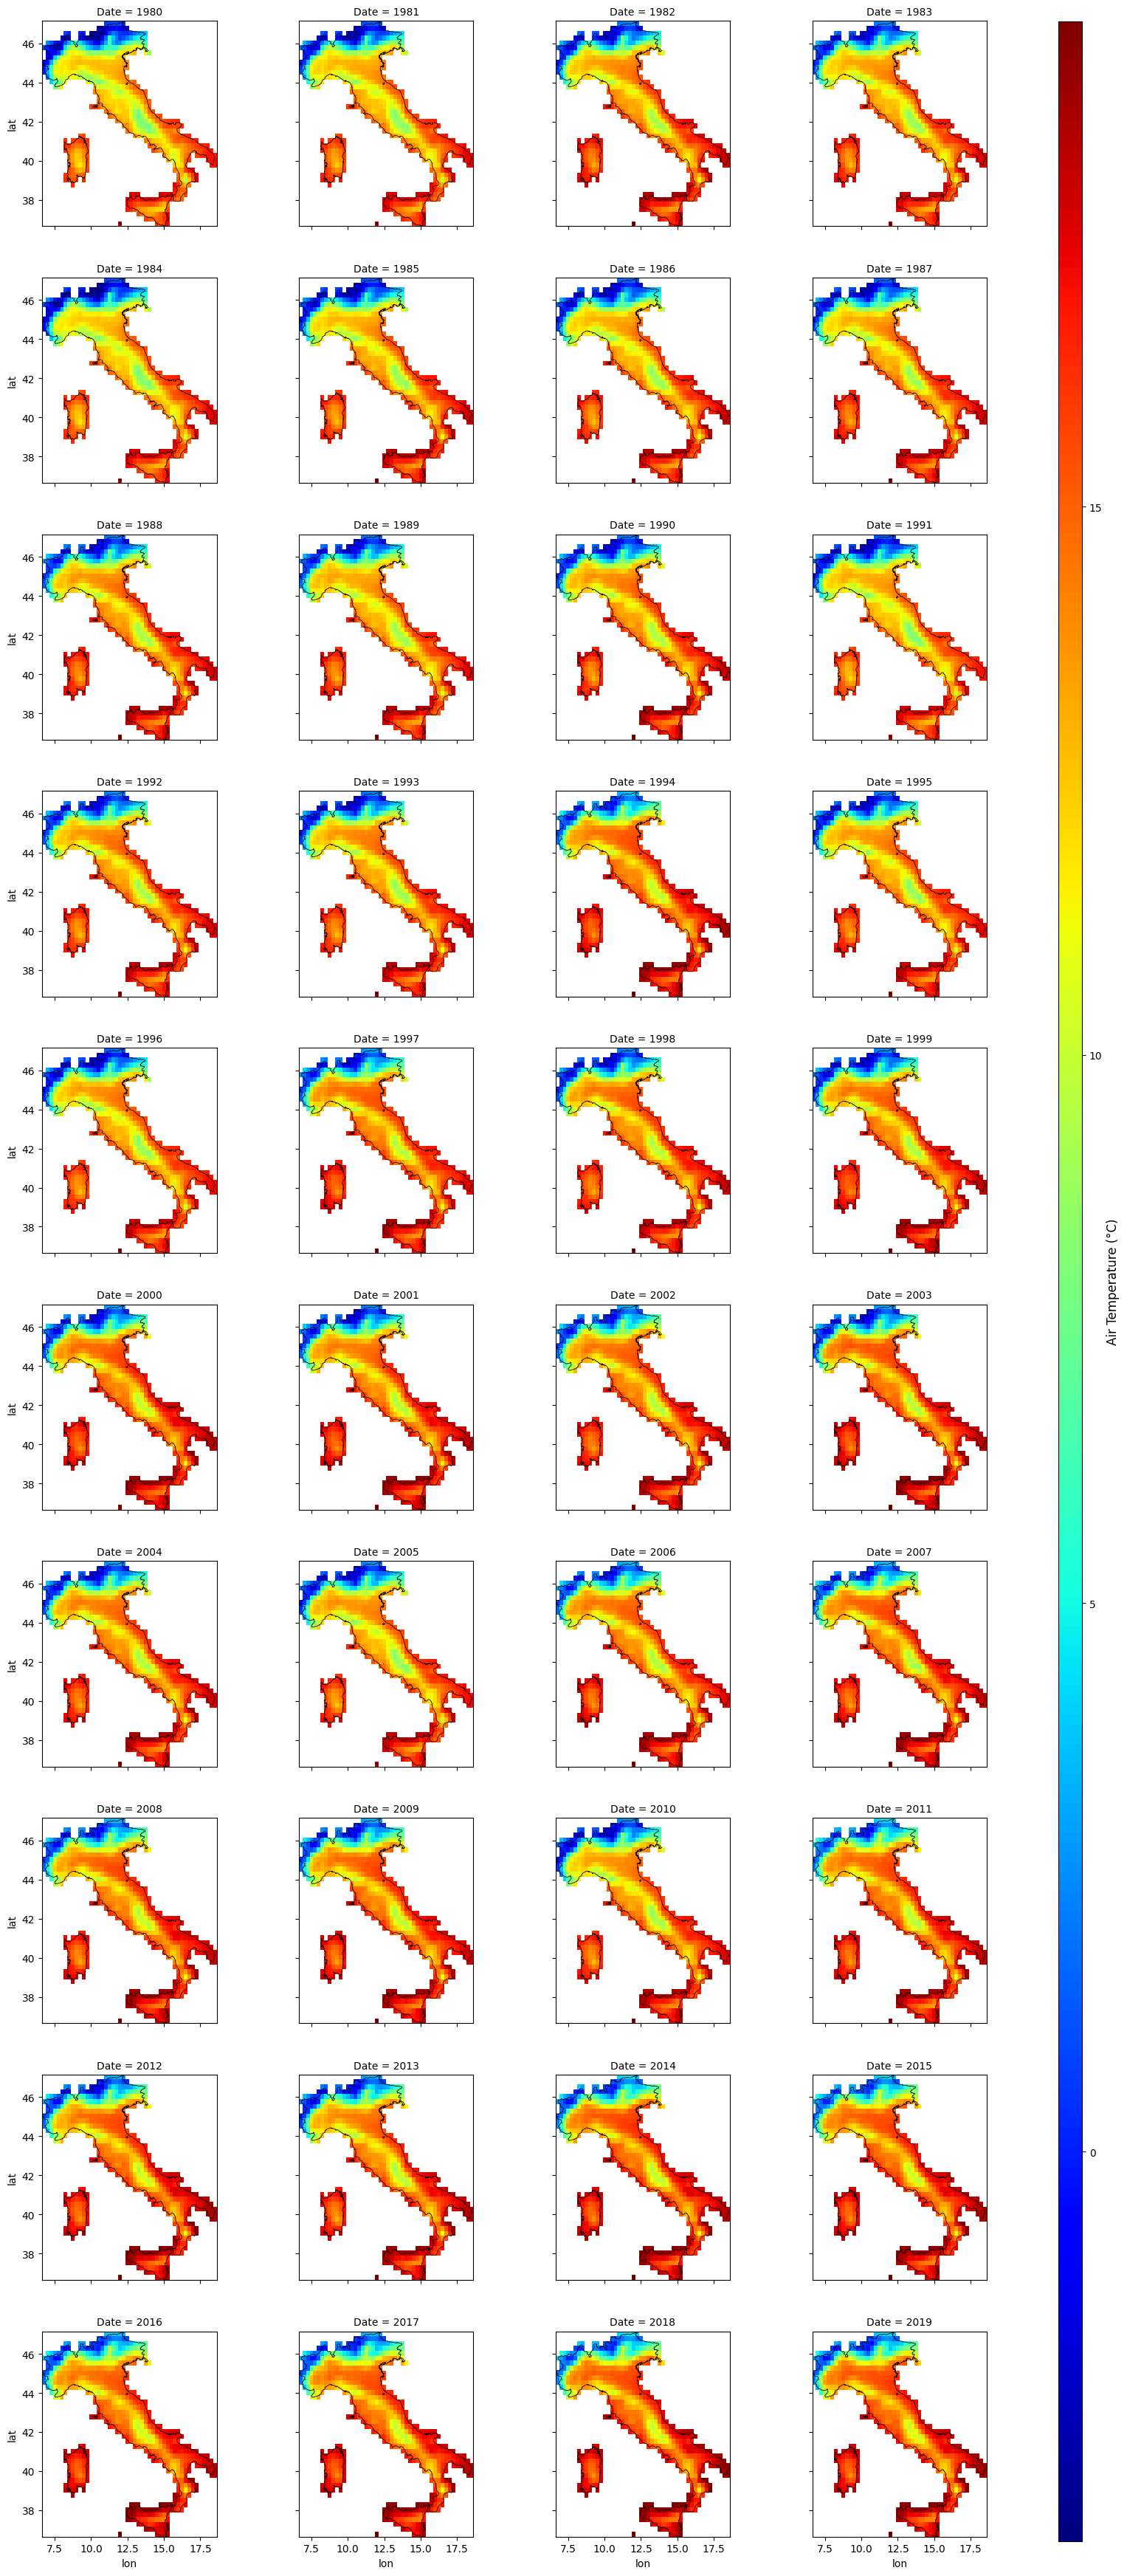

In [41]:
ds_mean=data_aggrigated
ds_mean['Date'] = ds_mean['Date'].dt.year

#############################################################
vmin = ds_mean[final_band].min().item()
vmax = ds_mean[final_band].max().item()


n_years = len(ds_mean['Date'])
ncols = 4
nrows = int(np.ceil(n_years / ncols))
figsize = (ncols * 4, nrows * 3.5)

# Create the faceted plot without colorbar
plot = ds_mean[final_band].plot(
    x='lon', y='lat',
    col='Date', col_wrap=ncols,
    cmap='jet',
    vmin=vmin, vmax=vmax,
    add_colorbar=False,
    figsize=figsize
)

# Get the figure object from the xarray plot
fig = plot.fig

# Adjust subplot spacing to make room for the colorbar
fig.subplots_adjust(right=0.88, wspace=0.15, hspace=0.25)

# Create a colorbar that spans the entire vertical height of all subplots
cbar_ax = fig.add_axes([0.92, 0.015, 0.02, 0.975])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])  # required to avoid warning
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{final_band} {data_unit}', fontsize=12)


# Overlay country boundary on each subplot with thicker lines
for ax in plot.axs.flat:
    country_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)  # Adjust thickness here

plt.savefig(f'{period} {operation} {final_band} {country_name}',dpi=600)
plt.show()

## Long Term Average

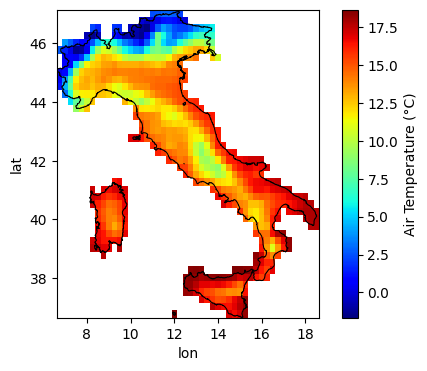

In [42]:
ds_mean_longterm = ds_mean.mean('Date')
vmin = ds_mean_longterm[final_band].min().item()
vmax = ds_mean_longterm[final_band].max().item()

fig, ax = plt.subplots(figsize=(6, 4))

# Plot the long-term mean of Air Temperature
pl = ds_mean_longterm[final_band].plot(
    x='lon', y='lat', cmap='jet', vmin=vmin, vmax=vmax, ax=ax
)

# Plot the country boundaries
country_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.75)

# Modify the colorbar title
cbar = pl.colorbar
cbar.set_label(f'{final_band} {data_unit}', fontsize=10)

# Show the plot
plt.savefig(f'Long Term {operation} {final_band} {country_name}', dpi=600)
plt.show()


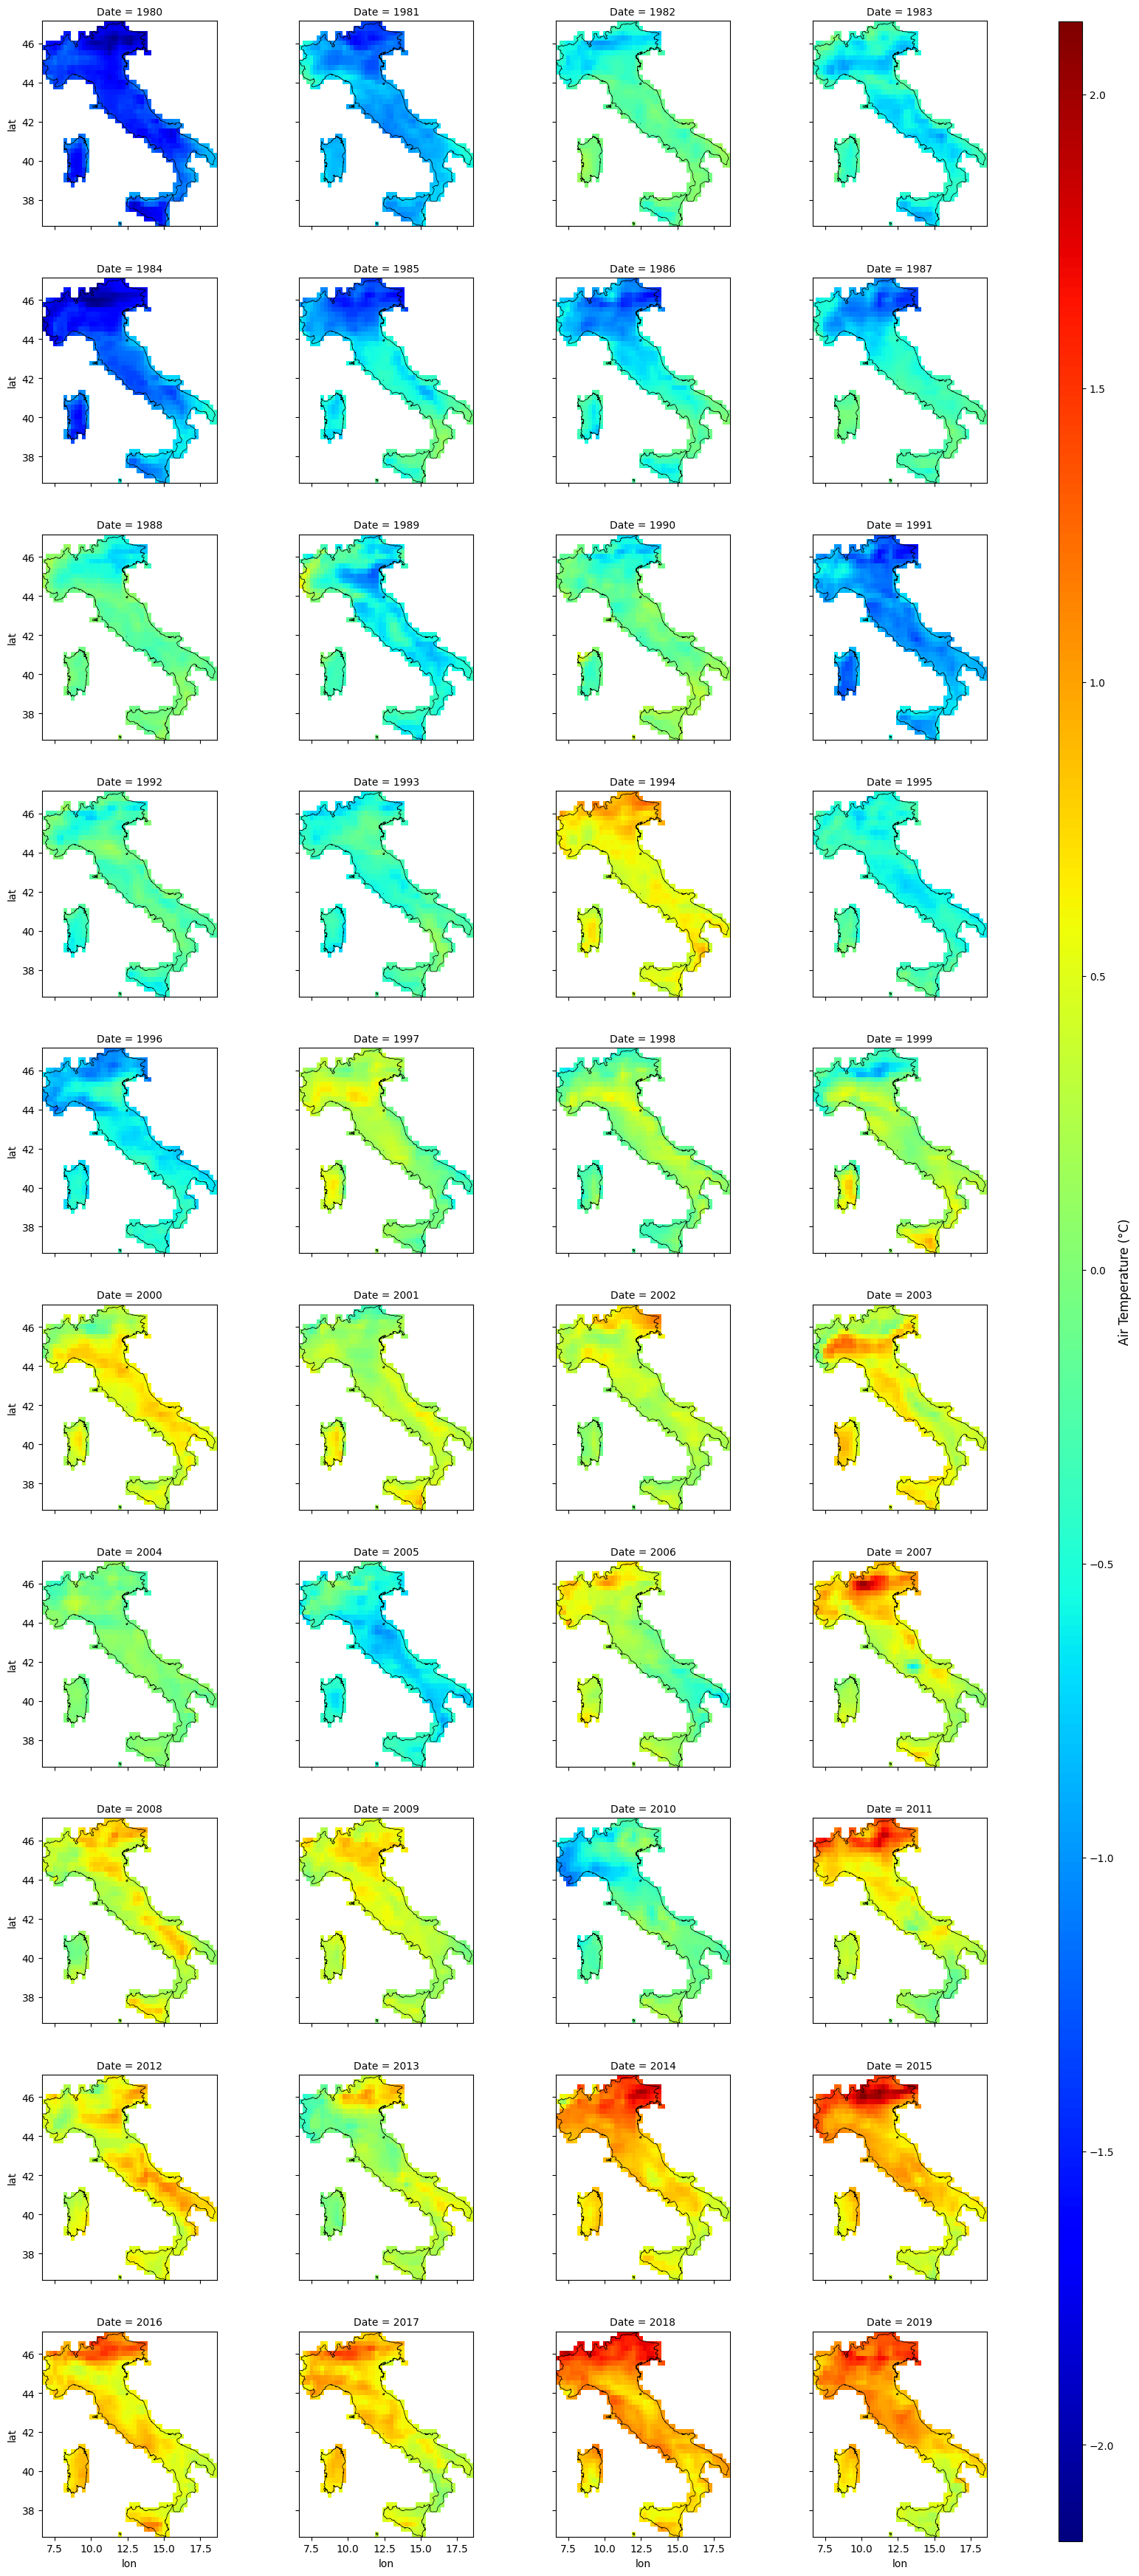

In [43]:
anomaly_lomgterm_mean = ds_mean-ds_mean_longterm

vmin = anomaly_lomgterm_mean[final_band].min().item()
vmax = anomaly_lomgterm_mean[final_band].max().item()


n_years = len(anomaly_lomgterm_mean['Date'])
ncols = 4
nrows = int(np.ceil(n_years / ncols))
figsize = (ncols * 4, nrows * 3.5)

# Create the faceted plot without colorbar
plot = anomaly_lomgterm_mean[final_band].plot(
    x='lon', y='lat',
    col='Date', col_wrap=ncols,
    cmap='jet',
    vmin=vmin, vmax=vmax,
    add_colorbar=False,
    figsize=figsize
)

# Get the figure object from the xarray plot
fig = plot.fig

# Adjust subplot spacing to make room for the colorbar
fig.subplots_adjust(right=0.88, wspace=0.15, hspace=0.25)

# Create a colorbar that spans the entire vertical height of all subplots
cbar_ax = fig.add_axes([0.92, 0.015, 0.02, 0.975])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])  # required to avoid warning
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{final_band} {data_unit}', fontsize=12)


# Overlay country boundary on each subplot with thicker lines
for ax in plot.axs.flat:
    country_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)  # Adjust thickness here

plt.savefig(f'Anomaly {period} {operation} {final_band} Respect to Long Term {operation} {country_name}',dpi=600)
plt.show()

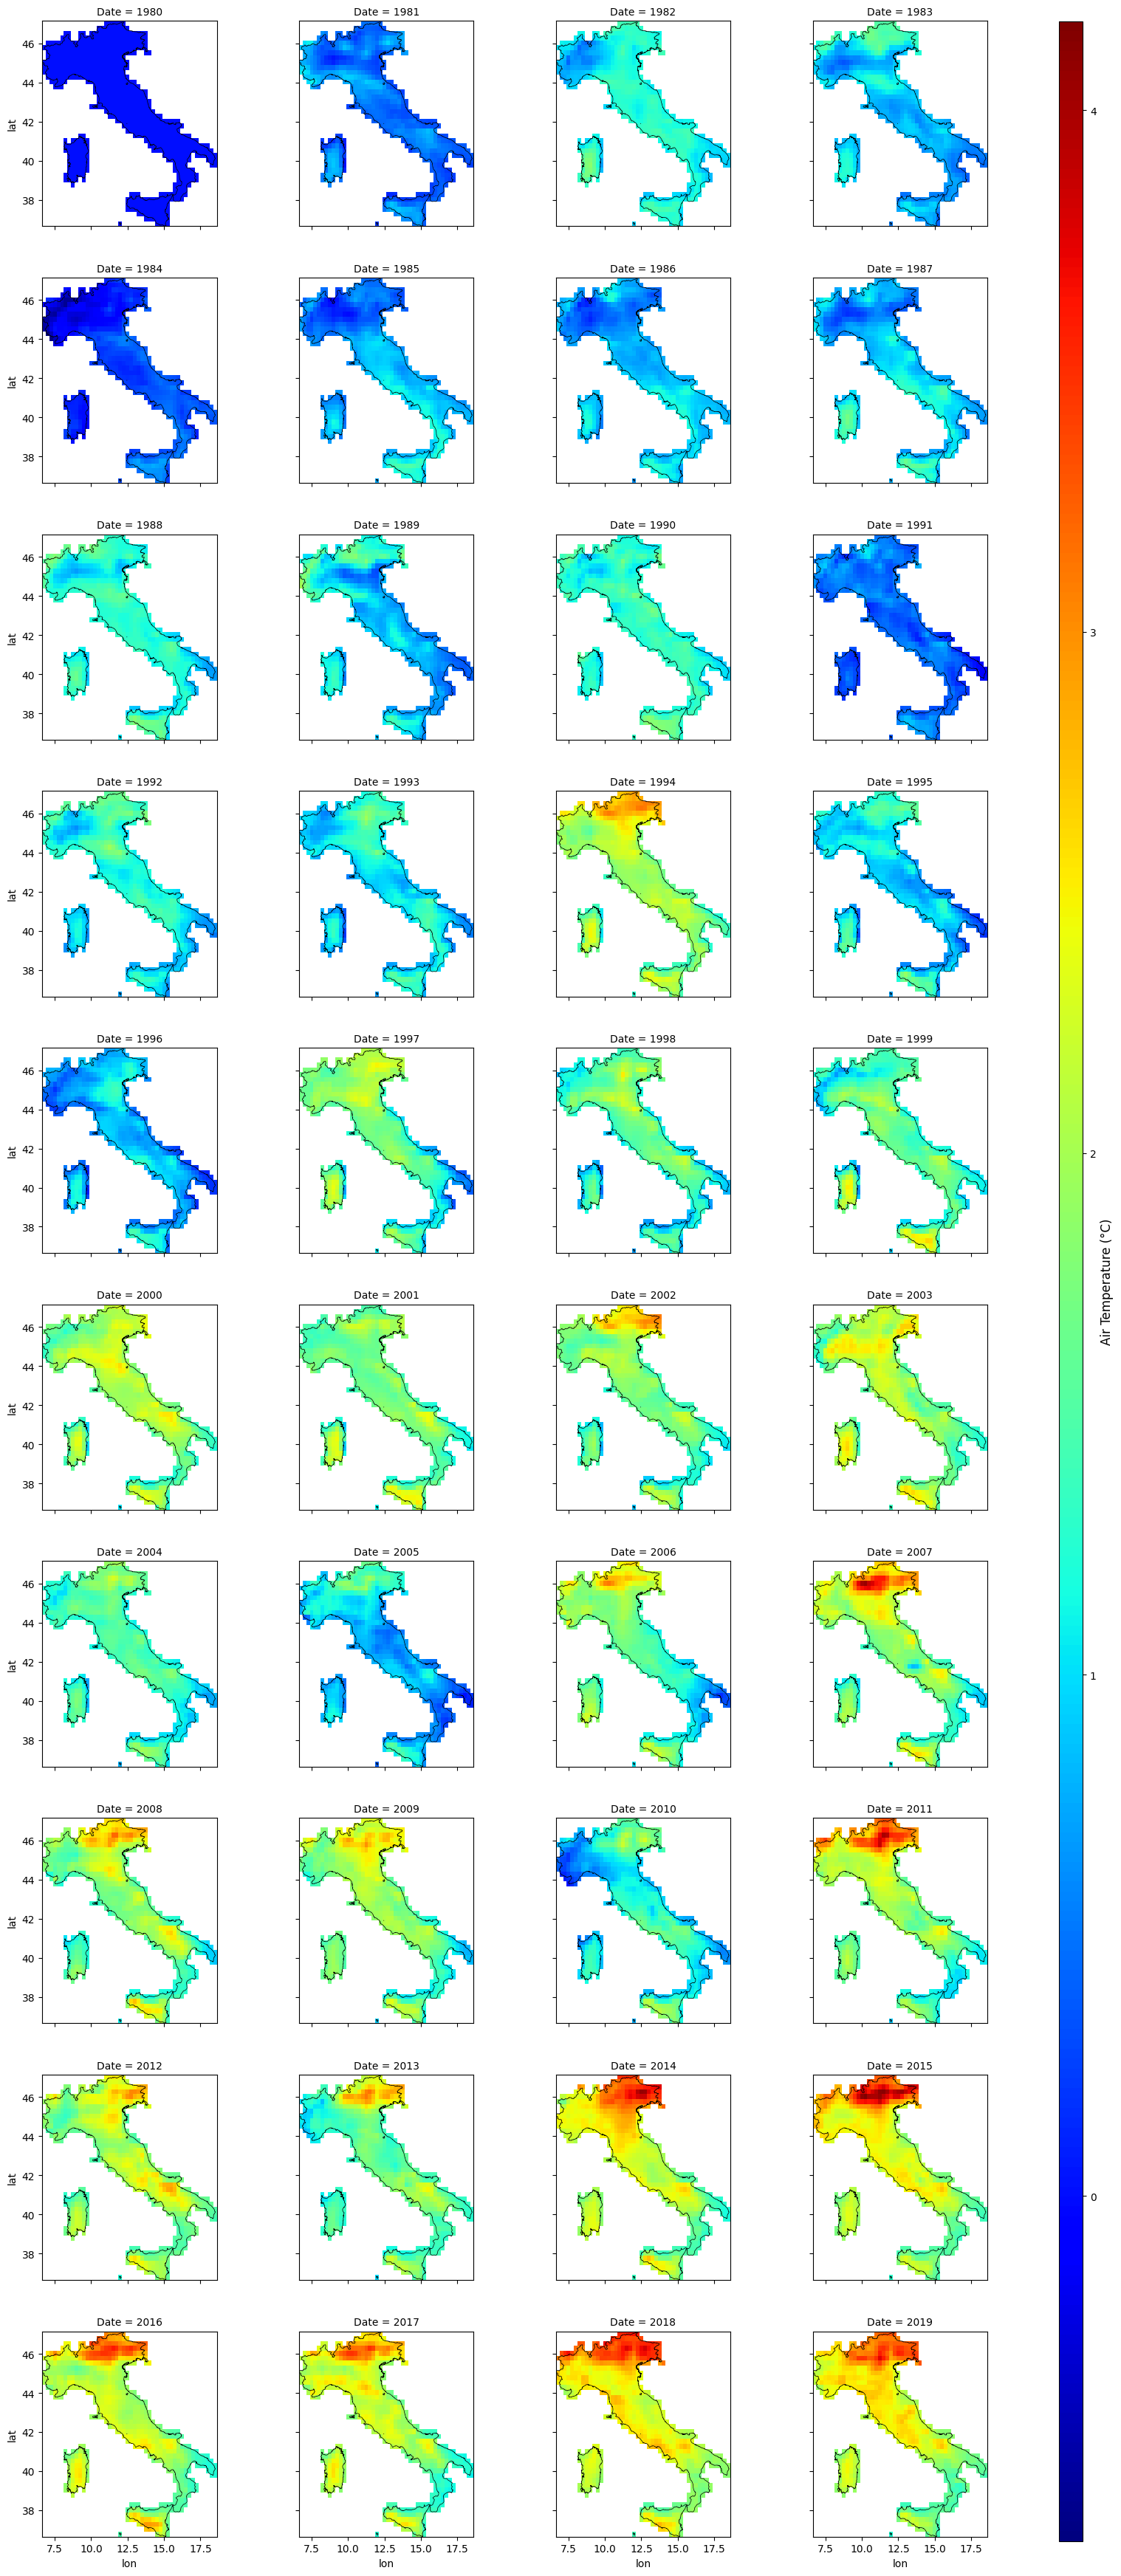

In [44]:
reference_date= 1980
reference = ds_mean.sel(Date=reference_date, method='nearest')
anomaly_reference = ds_mean - reference

vmin = anomaly_reference[final_band].min().item()
vmax = anomaly_reference[final_band].max().item()

n_years = len(anomaly_reference['Date'])
ncols = 4
nrows = int(np.ceil(n_years / ncols))
figsize = (ncols * 4, nrows * 3.5)

plot = anomaly_reference[final_band].plot(
    x='lon', y='lat',
    col='Date', col_wrap=ncols,
    cmap='jet',
    vmin=vmin, vmax=vmax,
    add_colorbar=False,
    figsize=figsize
)

fig = plot.fig
fig.subplots_adjust(right=0.88, wspace=0.15, hspace=0.25)

cbar_ax = fig.add_axes([0.92, 0.015, 0.02, 0.975])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{final_band} {data_unit}', fontsize=12)


# Overlay country boundary on each subplot with thicker lines
for ax in plot.axs.flat:
    country_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)  # Adjust thickness here

plt.savefig(f'Anomaly {operation} {final_band} Respect to Average {period} {reference_date} {country_name}',dpi=600)
plt.show()

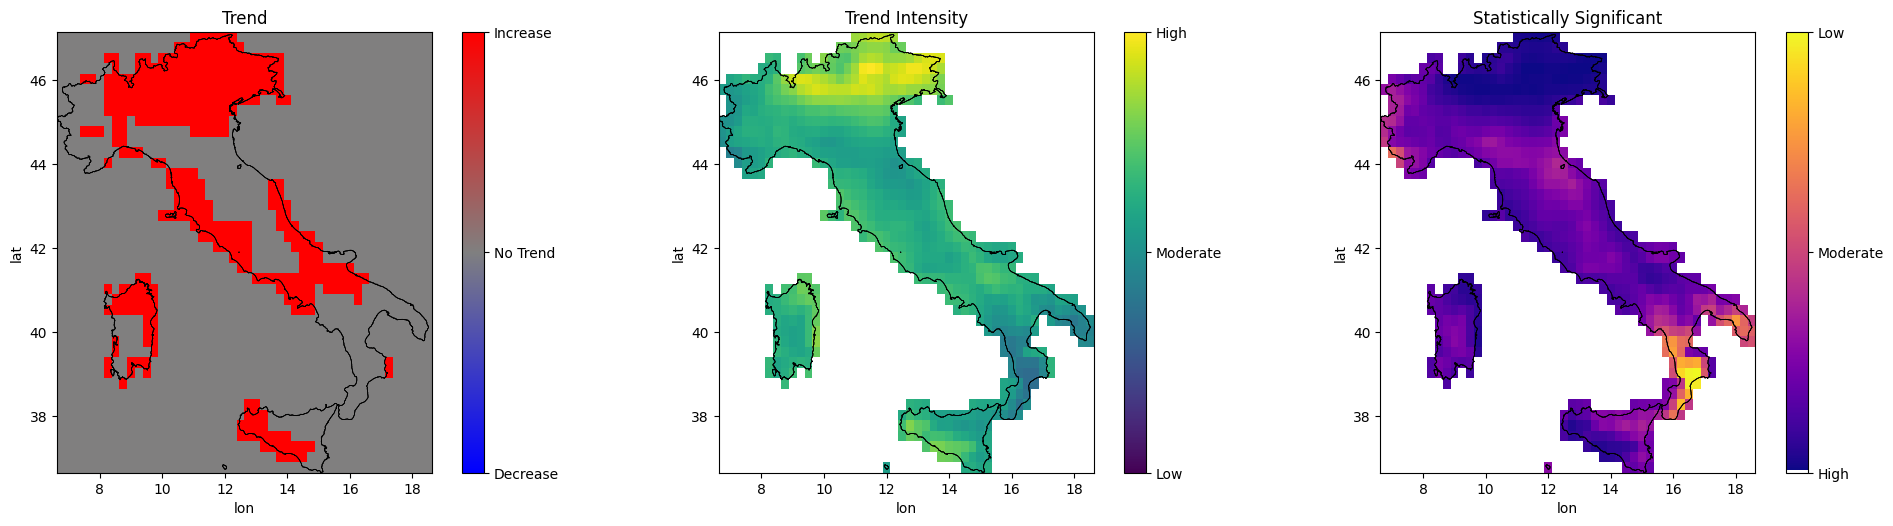

In [45]:
# Define a safe wrapper around the MK test
def mk_test(img):
    img = np.array(img)
    img = img[~np.isnan(img)]  # remove NaNs
    if len(img) <= 1:
        return 0, np.nan, np.nan  # Not enough data
    try:
        test = mk.original_test(img)
        trend_class = {'increasing': 1, 'decreasing': -1, 'no_trend': 0}
        trend_reclass = trend_class.get(test.trend, 0)
        return trend_reclass, test.s, test.p
    except:
        return 0, np.nan, np.nan  # Handle any unforeseen issues gracefully

# Apply function
change_trend, change_score, change_pval = xr.apply_ufunc(
    mk_test,
    data[final_band],
    input_core_dims=[['Date']],
    output_core_dims=[[], [], []],
    vectorize=True,
    dask='allowed',
    output_dtypes=['int', 'float64', 'float64']
)

# Rename and scale
change_trend = change_trend.rename('trend')
max_score = change_score.max().values
change_score = change_score.rename('score') /max_score
change_pval = change_pval.rename('p_value')

# Create custom colormap for trend: yellow (decreasing), white (no trend), red (increasing)
custom_cmap_tr = LinearSegmentedColormap.from_list(
    'blue-grey-red',
    ['blue', 'grey', 'red'],
    N=256
)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.tight_layout()


# Trend plot with custom colormap
c1 = change_trend.plot(x='lon', y='lat', ax=ax[0], cmap=custom_cmap_tr, vmin=-1, vmax=1)
ax[0].set_title('Trend')

# Customize the colorbar labels for the Trend plot
cbar = c1.colorbar  # Get the colorbar object
cbar.set_ticks([-1, 0, 1])  # Set the positions of the ticks
cbar.set_ticklabels(['Decrease', 'No Trend', 'Increase'])  # Set the custom labels
cbar.set_label('')  # Remove the colorbar title
# Overlay country boundary on each subplot
for ax_ in ax:
    country_gdf.boundary.plot(ax=ax_, edgecolor='black', linewidth=0.5)  # Adjust thickness here




c2 = change_score.plot(x='lon', y='lat', ax=ax[1], cmap='viridis', vmin=0, vmax=1)
ax[1].set_title('Trend Intensity')
cbar = c2.colorbar  # Get the colorbar object
cbar.set_ticks([0, 0.5, 1])  # Set the positions of the ticks
cbar.set_ticklabels(['Low', 'Moderate', 'High'])  # Set the custom labels
cbar.set_label('')  # Remove the colorbar title

# Overlay country boundary
for ax_ in ax:
    country_gdf.boundary.plot(ax=ax_, edgecolor='black', linewidth=0.5)

# P-value plot
c3 = change_pval.plot(x='lon', y='lat', ax=ax[2], cmap='plasma')
ax[2].set_title('Statistically Significant')
cbar = c3.colorbar  # Get the colorbar object


max_p = change_pval.max().values
cbar.set_ticks([0, max_p/2, max_p])  # Set the positions of the ticks
cbar.set_ticklabels(['High', 'Moderate', 'Low'])  # Set the custom labels
cbar.set_label('')  # Remove the colorbar title



# Overlay country boundary
for ax_ in ax:
    country_gdf.boundary.plot(ax=ax_, edgecolor='black', linewidth=0.5)


# Save the figure
plt.savefig(f'Trend {country_name}', dpi=600)

# Show the plot
plt.show()